# Syntactic Parsing - tf-IDF

In [1]:
#import necessary libraries
import numpy as np
import scipy as sp
import pandas as pd
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict,Counter
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ajith\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#load the data
with open("medical_train.dat",'r') as fh:
    lines= fh.readlines()


In [3]:
# breaks down sentences into words
tr_data=[l.split() for l in lines]

In [4]:
# appends train data into a separate doc for processing and separates the label and data
Class=[]
docs=[]
for i in range(0,len(tr_data)):
    Class.append(tr_data[i][0])
    docs.append(tr_data[i][1:])

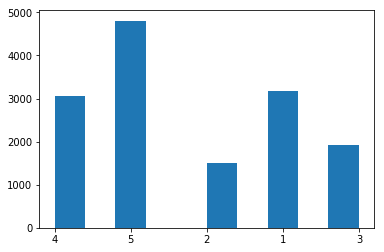

In [5]:
plt.hist(Class)
plt.show()

In [6]:
data=np.array(docs)
label=np.array(Class)

In [7]:
#splitting up of the data- 10000 for training and the remaining for testing
train_label=label[:10000]
test_label=label[10000:]



In [8]:
len(train_label),len(test_label)

(10000, 4438)

In [9]:
#using tfidf to obtain the sparse representation using syntactic parsing
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
a=TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False).fit_transform(data)

In [11]:
type(a)

scipy.sparse.csr.csr_matrix

In [12]:
def csr_info(mat, name="", non_empy=False):
    if non_empy:
        print("%s [nrows %d (%d non-empty), ncols %d (%d non-empty), nnz %d]" % (
                name, mat.shape[0], 
                sum(1 if mat.indptr[i+1] > mat.indptr[i] else 0 
                for i in range(mat.shape[0])), 
                mat.shape[1], len(np.unique(mat.indices)), 
                len(mat.data)))
    else:
        print( "%s [nrows %d, ncols %d, nnz %d]" % (name, 
                mat.shape[0], mat.shape[1], len(mat.data)) )

In [13]:
csr_info(a)

 [nrows 14438, ncols 107112, nnz 1593818]


In [14]:
train_data=a[:10000]
test_data=a[10000:]

In [15]:
csr_info(train_data)

 [nrows 10000, ncols 107112, nnz 1102362]


In [16]:
csr_info(test_data)

 [nrows 4438, ncols 107112, nnz 491456]


In [17]:
from sklearn.metrics import classification_report

# Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
clf=RandomForestClassifier()

In [20]:
clf.fit(train_data,train_label)

C:\Users\ajith\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
pred=clf.predict(test_data)

In [22]:
print(classification_report(test_label, pred))

              precision    recall  f1-score   support

           1       0.55      0.58      0.56       961
           2       0.18      0.12      0.15       440
           3       0.26      0.16      0.20       581
           4       0.53      0.53      0.53       922
           5       0.34      0.41      0.37      1534

   micro avg       0.41      0.41      0.41      4438
   macro avg       0.37      0.36      0.36      4438
weighted avg       0.40      0.41      0.40      4438



In [23]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().replace(' avg', '-avg').split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

In [24]:
report=classification_report(test_label, pred)

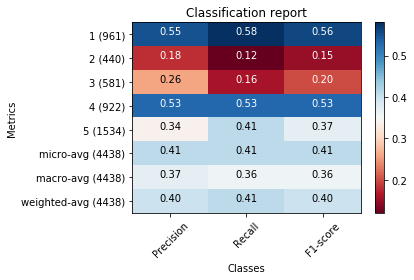

In [25]:
plot_classification_report(report)
plt.show()
plt.close()

# KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
clf1=KNeighborsClassifier(n_neighbors=30,metric='euclidean')

In [28]:
clf1.fit(train_data,train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=30, p=2,
           weights='uniform')

In [29]:
pred1=clf1.predict(test_data)

In [30]:
print(classification_report(test_label, pred1))

              precision    recall  f1-score   support

           1       0.63      0.80      0.71       961
           2       0.54      0.48      0.51       440
           3       0.57      0.36      0.44       581
           4       0.58      0.82      0.68       922
           5       0.56      0.42      0.48      1534

   micro avg       0.59      0.59      0.59      4438
   macro avg       0.58      0.58      0.56      4438
weighted avg       0.58      0.59      0.57      4438



In [31]:
report1=classification_report(test_label, pred)

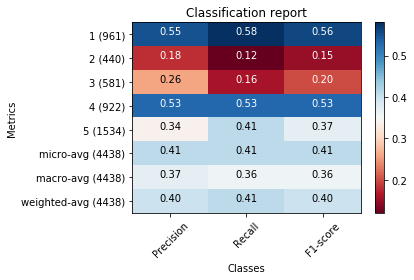

In [32]:
plot_classification_report(report1)
plt.show()
plt.close()

In [33]:
clf2=KNeighborsClassifier(n_neighbors=37,metric='cosine')

In [34]:
clf2.fit(train_data,train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
           metric_params=None, n_jobs=None, n_neighbors=37, p=2,
           weights='uniform')

In [35]:
pred2=clf2.predict(test_data)

In [36]:
print(classification_report(test_label, pred2))

              precision    recall  f1-score   support

           1       0.63      0.82      0.71       961
           2       0.55      0.47      0.50       440
           3       0.59      0.34      0.43       581
           4       0.58      0.82      0.68       922
           5       0.56      0.43      0.49      1534

   micro avg       0.59      0.59      0.59      4438
   macro avg       0.58      0.58      0.56      4438
weighted avg       0.58      0.59      0.57      4438



In [37]:
report2=classification_report(test_label, pred2)

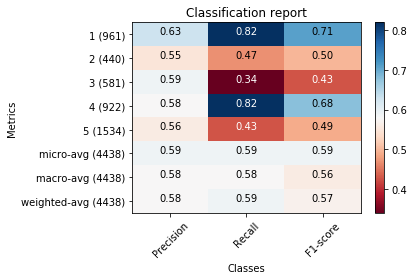

In [38]:
plot_classification_report(report2)
plt.show()
plt.close()

# Naive Bayes

In [39]:
from sklearn.naive_bayes import GaussianNB

In [40]:
clf3=GaussianNB()

In [42]:
clf3.fit(train_data.toarray(),train_label)

GaussianNB(priors=None, var_smoothing=1e-09)

In [43]:
pred3=clf3.predict(test_data.toarray())

In [44]:
print(classification_report(test_label, pred3))

              precision    recall  f1-score   support

           1       0.52      0.45      0.48       961
           2       0.17      0.13      0.15       440
           3       0.25      0.16      0.20       581
           4       0.47      0.39      0.43       922
           5       0.32      0.45      0.38      1534

   micro avg       0.37      0.37      0.37      4438
   macro avg       0.35      0.32      0.33      4438
weighted avg       0.37      0.37      0.36      4438



In [45]:
report3=classification_report(test_label, pred3)

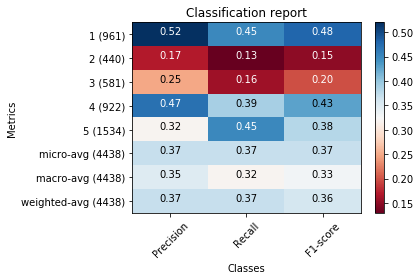

In [46]:
plot_classification_report(report3)
plt.show()
plt.close()

# Extra Trees Classifier

In [47]:
from sklearn.ensemble import ExtraTreesClassifier

In [48]:
clf4=ExtraTreesClassifier(n_estimators=200, max_features=200,random_state=7)

In [49]:
clf4.fit(train_data,train_label)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=200, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=7, verbose=0, warm_start=False)

In [51]:
pred4=clf4.predict(test_data)

In [52]:
print(classification_report(test_label, pred4))

              precision    recall  f1-score   support

           1       0.62      0.61      0.61       961
           2       0.18      0.11      0.13       440
           3       0.26      0.12      0.17       581
           4       0.58      0.55      0.57       922
           5       0.38      0.51      0.44      1534

   micro avg       0.45      0.45      0.45      4438
   macro avg       0.40      0.38      0.38      4438
weighted avg       0.44      0.45      0.44      4438



In [53]:
report4=classification_report(test_label, pred4)

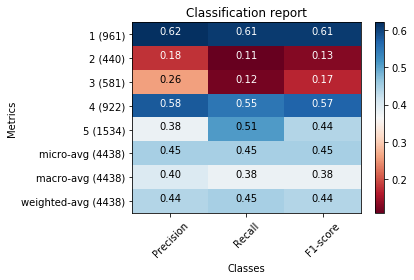

In [54]:
plot_classification_report(report4)
plt.show()
plt.close()

# Random Forest Classifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [108]:
clf5 = RandomForestClassifier(n_estimators=200,max_features=1000, max_depth=40,random_state=1)

In [109]:
clf5.fit(train_data,train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features=1000, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [110]:
pred5=clf5.predict(test_data)

In [111]:
print(classification_report(test_label,pred5))

              precision    recall  f1-score   support

           1       0.63      0.63      0.63       961
           2       0.29      0.16      0.20       440
           3       0.31      0.10      0.15       581
           4       0.59      0.59      0.59       922
           5       0.40      0.56      0.47      1534

   micro avg       0.48      0.48      0.48      4438
   macro avg       0.44      0.41      0.41      4438
weighted avg       0.47      0.48      0.46      4438



In [112]:
report5=classification_report(test_label, pred5)

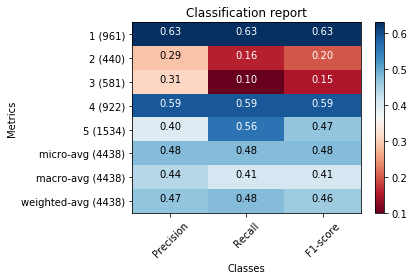

In [113]:
plot_classification_report(report5)
plt.show()
plt.close()

# Logistic Regression

In [114]:
from sklearn.linear_model import LogisticRegression

In [115]:
clf6=LogisticRegression()

In [116]:
clf6.fit(train_data,train_label)

C:\Users\ajith\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ajith\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [117]:
pred6=clf6.predict(test_data)

In [118]:
print(classification_report(test_label,pred6))

              precision    recall  f1-score   support

           1       0.70      0.74      0.72       961
           2       0.46      0.28      0.35       440
           3       0.50      0.28      0.36       581
           4       0.66      0.63      0.64       922
           5       0.46      0.59      0.51      1534

   micro avg       0.56      0.56      0.56      4438
   macro avg       0.56      0.50      0.52      4438
weighted avg       0.56      0.56      0.55      4438



In [119]:
report6=classification_report(test_label, pred6)

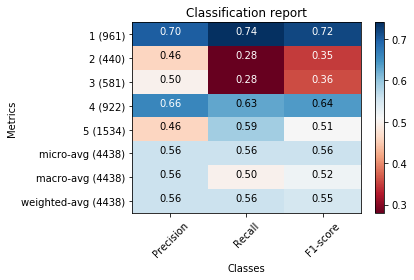

In [120]:
plot_classification_report(report6)
plt.show()
plt.close()